## Graph Construction from Data:

In [2]:
import pandas as pd
import networkx as nx
import pickle

# File path
file_path = r'Data/02-20-2018.csv'

# Chunk size (adjust based on available RAM)
chunk_size = 1000000

# Create an empty directed graph
G = nx.DiGraph()

# Stream CSV in chunks
for chunk in pd.read_csv(file_path, usecols=["Src IP", "Dst IP", "TotLen Fwd Pkts", "TotLen Bwd Pkts", "Label"], 
                         chunksize=chunk_size, low_memory=False):

    # Drop rows with missing IPs
    chunk.dropna(subset=["Src IP", "Dst IP"], inplace=True)

    # Iterate over rows
    for _, row in chunk.iterrows():
        try:
            src = row["Src IP"]
            dst = row["Dst IP"]
            fwd_bytes = float(row["TotLen Fwd Pkts"])
            bwd_bytes = float(row["TotLen Bwd Pkts"])
            
            # Forward direction: src -> dst
            if G.has_edge(src, dst):
                G[src][dst]["weight"] += fwd_bytes
            else:
                G.add_edge(src, dst, weight=fwd_bytes)
            
            # Backward direction: dst -> src
            if G.has_edge(dst, src):
                G[dst][src]["weight"] += bwd_bytes
            else:
                G.add_edge(dst, src, weight=bwd_bytes)

        except (KeyError, ValueError):
            continue  # Skip problematic rows

# Graph stats
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Save the graph
with open("network_graph.pkl", "wb") as f:
    pickle.dump(G, f)

# Optional: Save a lightweight graph summary
summary = {
    "nodes": G.number_of_nodes(),
    "edges": G.number_of_edges(),
}
with open("graph_summary.txt", "w") as f:
    f.write(str(summary))


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [32]:
import pandas as pd
import pickle

# File path
file_path = r'Data/02-20-2018.csv'

# Chunk size (adjust based on available RAM)
chunk_size = 1000000

# Dictionary to store labels for each unique IP
label_mapping = {}

# Stream CSV in chunks
for chunk in pd.read_csv(file_path, usecols=["Src IP", "Dst IP", "Label"], chunksize=chunk_size, low_memory=False):

    # Drop rows with missing IPs
    chunk.dropna(subset=["Src IP", "Dst IP"], inplace=True)

    # Iterate over rows and add labels to dictionary
    for _, row in chunk.iterrows():
        src_ip = row["Src IP"]
        dst_ip = row["Dst IP"]
        label = row["Label"]

        # Assign labels to each IP
        label_mapping[src_ip] = label
        label_mapping[dst_ip] = label

# Save the label mapping as a pickle file
with open("label_mapping.pkl", "wb") as f:
    pickle.dump(label_mapping, f)

# Optional: To check if the labels are saved correctly
print(f"Saved labels for first 5 nodes: {dict(list(label_mapping.items())[:5])}")


Saved labels for first 5 nodes: {'94.231.103.172': 'Benign', '172.31.69.25': 'DDoS attacks-LOIC-HTTP', '8.6.0.1': 'Benign', '8.0.6.4': 'Benign', '91.185.191.213': 'Benign'}


### Computing egonet features

In [3]:
import pandas as pd
import networkx as nx
import pickle

In [4]:
with open("network_graph.pkl", "rb") as f:
    G = pickle.load(f)

In [5]:
import numpy as np

egonet_features = {}

for node in G.nodes():
    neighbors = list(G.successors(node)) + list(G.predecessors(node))
    egonet_nodes = set(neighbors + [node])
    subgraph = G.subgraph(egonet_nodes).copy()

    N_i = len(subgraph.nodes)
    E_i = len(subgraph.edges)
    W_i = sum([d["weight"] for u, v, d in subgraph.edges(data=True)])
    
    # Weighted adjacency matrix and its top eigenvalue
    W_matrix = nx.to_numpy_array(subgraph, weight="weight")
    if W_matrix.shape[0] > 1:
        lambda_w = max(np.linalg.eigvals(W_matrix)).real
    else:
        lambda_w = 0

    # Store features
    egonet_features[node] = {
        "N_i": N_i,
        "E_i": E_i,
        "W_i": W_i,
        "lambda_w": lambda_w,
    }

# Save the dictionary
with open("egonet_features.pkl", "wb") as f:
    pickle.dump(egonet_features, f)



KeyboardInterrupt: 

In [6]:

# Save the dictionary
with open("egonet_features.pkl", "wb") as f:
    pickle.dump(egonet_features, f)


### Fitting power laws

In [ ]:
from scipy.optimize import curve_fit

def power_law(x, C, alpha):
    return C * np.power(x, alpha)

def fit_powerlaw(x_vals, y_vals):
    x = np.array(x_vals)
    y = np.array(y_vals)
    valid = (x > 2) & (y > 0)
    x = x[valid]
    y = y[valid]
    popt, _ = curve_fit(power_law, x, y)
    return popt  # returns C, alpha

def outlier_score(y, y_hat):
    return max(y, y_hat) / min(y, y_hat) * np.log(abs(y - y_hat) + 1)


### Counting outlier scores

In [ ]:

Ni = [v["N_i"] for v in egonet_features.values()]
Ei = [v["E_i"] for v in egonet_features.values()]
C_edpl, alpha_edpl = fit_powerlaw(Ni, Ei)

scores_edpl = {}
for node, feats in egonet_features.items():
    x = feats["N_i"]
    y = feats["E_i"]
    y_hat = power_law(x, C_edpl, alpha_edpl)
    score = outlier_score(y, y_hat)
    scores_edpl[node] = score


# Save the dictionary
with open("score_edpl.pkl", "wb") as f:
    pickle.dump(scores_edpl, f)



In [ ]:
# Extract values
E_vals = [v["E_i"] for v in egonet_features.values()]
W_vals = [v["W_i"] for v in egonet_features.values()]

# Fit power law
C_ewpl, alpha_ewpl = fit_powerlaw(E_vals, W_vals)

# Compute outlier scores
scores_ewpl = {}
for node, feats in egonet_features.items():
    x = feats["E_i"]
    y = feats["W_i"]
    y_hat = power_law(x, C_ewpl, alpha_ewpl)
    score = outlier_score(y, y_hat)
    scores_ewpl[node] = score

with open("score_ewpl.pkl", "wb") as f:
    pickle.dump(scores_ewpl, f)


/tmp/ipykernel_22314/878669918.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  return max(y, y_hat) / min(y, y_hat) * np.log(abs(y - y_hat) + 1)


In [ ]:
W_vals = [v["W_i"] for v in egonet_features.values()]
L_vals = [v["lambda_w"] for v in egonet_features.values()]

# Fit power law
C_elwpl, alpha_elwpl = fit_powerlaw(W_vals, L_vals)

# Compute outlier scores
scores_elwpl = {}
for node, feats in egonet_features.items():
    x = feats["W_i"]
    y = feats["lambda_w"]
    y_hat = power_law(x, C_elwpl, alpha_elwpl)
    score = outlier_score(y, y_hat)
    scores_elwpl[node] = score

with open("score_elwpl.pkl", "wb") as f:
    pickle.dump(scores_elwpl, f)


/tmp/ipykernel_22314/878669918.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return max(y, y_hat) / min(y, y_hat) * np.log(abs(y - y_hat) + 1)
/tmp/ipykernel_22314/878669918.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  return max(y, y_hat) / min(y, y_hat) * np.log(abs(y - y_hat) + 1)


### Combine with LOF

In [5]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

# Prepare features for LOF
X_lof = np.array([[v["N_i"], v["E_i"], v["W_i"], v["lambda_w"]] for v in egonet_features.values()])
lof_model = LocalOutlierFactor(n_neighbors=20, metric="euclidean")
lof_scores = -lof_model.fit_predict(X_lof)  # higher means more outlier

# Normalize
def safe_normalize(scores_dict):
    vals = np.array(list(scores_dict.values()))
    vals = np.nan_to_num(vals, nan=0.0, posinf=0.0, neginf=0.0)
    return MinMaxScaler().fit_transform(vals.reshape(-1, 1)).flatten()

edpl_scores_norm = safe_normalize(scores_edpl)
ewpl_scores_norm = safe_normalize(scores_ewpl)
elwpl_scores_norm = safe_normalize(scores_elwpl)
lof_scores_norm = safe_normalize(dict(zip(egonet_features.keys(), lof_scores)))


# Combine
combined_scores = {
    node: edpl_scores_norm[i] + lof_scores_norm[i] + ewpl_scores_norm[i] + elwpl_scores_norm[i]
    for i, node in enumerate(egonet_features.keys())
}


NameError: name 'scores_edpl' is not defined

In [13]:
from collections import defaultdict, Counter

ip_labels = defaultdict(list)

for chunk in pd.read_csv(file_path, usecols=["Src IP", "Dst IP", "Label"], chunksize=chunk_size, low_memory=False):
    chunk.dropna(subset=["Src IP", "Dst IP"], inplace=True)
    for _, row in chunk.iterrows():
        ip_labels[row["Src IP"]].append(row["Label"])
        ip_labels[row["Dst IP"]].append(row["Label"])

# Final label per IP: use most common label
ip_majority_label = {ip: Counter(labels).most_common(1)[0][0] for ip, labels in ip_labels.items()}


In [45]:
with open("ip_majority_label.pkl", "wb") as f:
    pickle.dump(ip_majority_label, f)

In [83]:

# Sort and view top 10
sorted_outliers = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
top_outliers = sorted_outliers[:10]
for i, (node, score) in enumerate(top_outliers):
    print(f"{i+1}. Node: {node}, Combined Outlier Score: {score:.4f}")

1. Node: 185.92.73.85, Combined Outlier Score: 2.6585
2. Node: 23.36.32.43, Combined Outlier Score: 2.4592
3. Node: 121.8.141.138, Combined Outlier Score: 2.3405
4. Node: 210.206.216.138, Combined Outlier Score: 2.3405
5. Node: 121.8.141.142, Combined Outlier Score: 2.3405
6. Node: 58.63.230.158, Combined Outlier Score: 2.3405
7. Node: 18.219.32.43, Combined Outlier Score: 2.0740
8. Node: 52.14.136.135, Combined Outlier Score: 2.0700
9. Node: 18.219.9.1, Combined Outlier Score: 2.0695
10. Node: 18.216.200.189, Combined Outlier Score: 2.0678


In [84]:
outlier_nodes = [node for node, _ in sorted_outliers[:17]]  


true_positives = [ip for ip in outlier_nodes if ip_majority_label.get(ip, "Benign") != "Benign"]
false_positives = [ip for ip in outlier_nodes if ip_majority_label.get(ip, "Benign") == "Benign"]

print(f"True Positives: {len(true_positives)}")
print(f"False Positives: {len(false_positives)}")


True Positives: 9
False Positives: 8


In [85]:
# Get all IPs labeled malicious
malicious_ips = {ip for ip, label in ip_majority_label.items() if label != "Benign"}

tp = len(set(outlier_nodes) & malicious_ips)
fp = len(set(outlier_nodes) - malicious_ips)
fn = len(malicious_ips - set(outlier_nodes))

precision = tp / (tp + fp + 1e-6)
recall = tp / (tp + fn + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Precision: 0.5294
Recall:    0.8182
F1 Score:  0.6429


In [86]:
for ip in top_outliers:
    label = ip_majority_label.get(ip[0], "UNKNOWN")
    print(f"Outlier: {ip[0]} - Label: {label}")


Outlier: 185.92.73.85 - Label: Benign
Outlier: 23.36.32.43 - Label: Benign
Outlier: 121.8.141.138 - Label: Benign
Outlier: 210.206.216.138 - Label: Benign
Outlier: 121.8.141.142 - Label: Benign
Outlier: 58.63.230.158 - Label: Benign
Outlier: 18.219.32.43 - Label: DDoS attacks-LOIC-HTTP
Outlier: 52.14.136.135 - Label: DDoS attacks-LOIC-HTTP
Outlier: 18.219.9.1 - Label: DDoS attacks-LOIC-HTTP
Outlier: 18.216.200.189 - Label: DDoS attacks-LOIC-HTTP


Graph Deviation


In [7]:
import numpy as np
import pickle

# Extract feature vectors
features = {
    "N_i": np.array([v["N_i"] for v in egonet_features.values()]),
    "E_i": np.array([v["E_i"] for v in egonet_features.values()]),
    "W_i": np.array([v["W_i"] for v in egonet_features.values()]),
    "lambda_w": np.array([v["lambda_w"] for v in egonet_features.values()])
}

# Compute mean and std
means = {k: np.mean(v) for k, v in features.items()}
stds = {k: np.std(v) + 1e-9 for k, v in features.items()}

# Compute z-scores
z_scores = {k: (v - means[k]) / stds[k] for k, v in features.items()}

# Aggregate
nodes = list(egonet_features.keys())
score_graph_deviance = {
    node: sum(abs(z_scores[k][i]) for k in z_scores)
    for i, node in enumerate(nodes)
}

# Save
with open("score_graph_deviance.pkl", "wb") as f:
    pickle.dump(score_graph_deviance, f)


In [1]:
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler

# Load all scores
def load_score(file):
    with open(file, "rb") as f:
        return pickle.load(f)

scores = {
    "EDPL": load_score("score_edpl.pkl"),
    "EWPL": load_score("score_ewpl.pkl"),
    "ELWPL": load_score("score_elwpl.pkl"),
    "GraphDeviance": load_score("score_graph_deviance.pkl")
}

# Combine into DataFrame
df_scores = pd.DataFrame(scores).fillna(0)

# Replace inf/-inf with 0
df_scores.replace([float('inf'), float('-inf')], 0, inplace=True)

# Normalize for comparison
scaler = MinMaxScaler()
df_scores_scaled = pd.DataFrame(scaler.fit_transform(df_scores), columns=df_scores.columns, index=df_scores.index)

# View top anomalies
top_anomalies = df_scores_scaled.sort_values(by="GraphDeviance", ascending=False).head(30)
print(top_anomalies)



                    EDPL      EWPL     ELWPL  GraphDeviance
172.31.69.25    0.636131  0.000638  0.101924       1.000000
13.107.4.50     0.435761  0.002357  0.303627       0.527790
23.36.32.43     0.457617  0.001562  1.000000       0.376157
23.15.8.139     0.159679  0.004225  0.051090       0.306614
23.15.8.129     0.129994  0.003612  0.053541       0.283226
18.218.55.126   0.871684  0.016439  0.175733       0.273309
18.219.5.43     0.871684  0.015652  0.177154       0.265213
18.218.229.235  0.871684  0.015352  0.179340       0.263971
18.216.24.42    0.871684  0.014202  0.180515       0.250490
18.216.200.189  0.871684  0.014024  0.182051       0.249833
18.219.9.1      0.871684  0.013558  0.184252       0.246011
18.218.11.51    0.871684  0.013782  0.181375       0.245912
23.219.88.11    0.531287  0.000599  0.042430       0.238232
52.14.136.135   0.871684  0.012663  0.185695       0.235382
18.219.32.43    0.871684  0.010075  0.192223       0.204569
23.219.88.59    0.245100  0.003103  0.04

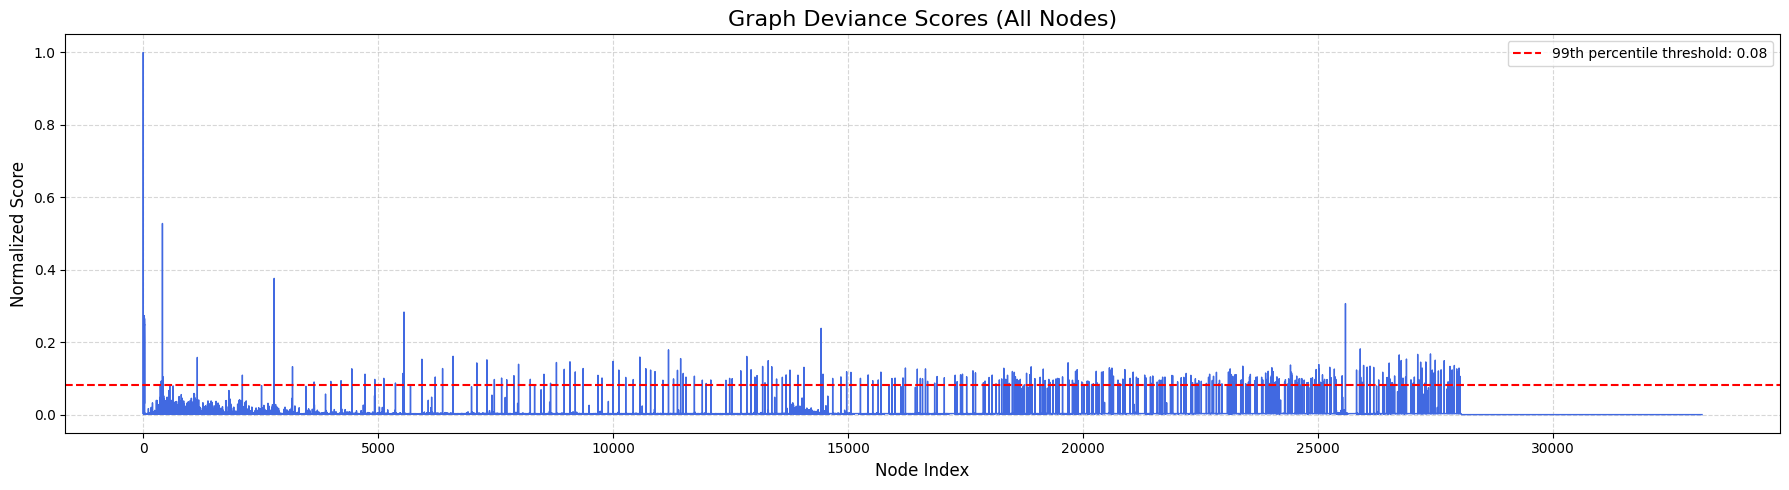

In [6]:
import matplotlib.pyplot as plt

# Plot a smooth line instead of cluttered bars
plt.figure(figsize=(18, 5))
plt.plot(df_scores_scaled["GraphDeviance"].values, color="royalblue", linewidth=1)
plt.title("Graph Deviance Scores (All Nodes)", fontsize=16)
plt.xlabel("Node Index", fontsize=12)
plt.ylabel("Normalized Score", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# Optional: highlight a threshold (e.g., top 1% anomaly cutoff)
threshold = df_scores_scaled["GraphDeviance"].quantile(0.99)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'99th percentile threshold: {threshold:.2f}')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
top_ids = top_anomalies.index.tolist()
print("Top anomalous nodes/IPs:")
print(top_ids)
top_anomalies.to_csv("top_graph_deviance_anomalies.csv")


Top anomalous nodes/IPs:
['172.31.69.25', '13.107.4.50', '23.36.32.43', '23.15.8.139', '23.15.8.129', '18.218.55.126', '18.219.5.43', '18.218.229.235', '18.216.24.42', '18.216.200.189', '18.219.9.1', '18.218.11.51', '23.219.88.11', '52.14.136.135', '18.219.32.43', '23.219.88.59', '172.31.66.63', '172.31.66.111', '172.31.65.6', '172.31.65.100', '172.31.64.99', '172.31.67.28', '172.31.66.42', '172.31.64.115', '172.31.66.82', '172.31.65.25', '172.31.64.76', '172.31.65.123', '172.31.66.15', '172.31.65.117']


In [8]:
# Load the label mapping (if not already loaded)
with open("label_mapping.pkl", "rb") as f:
    label_mapping = pickle.load(f)

# Extract labels for the top anomalous nodes
top_labels = {ip: label_mapping.get(ip, "Unknown") for ip in top_ids}

# Print the results
print("Labels for Top Anomalous IPs:")
for ip, label in top_labels.items():
    print(f"{ip}: {label}")


Labels for Top Anomalous IPs:
172.31.69.25: DDoS attacks-LOIC-HTTP
13.107.4.50: Benign
23.36.32.43: Benign
23.15.8.139: Benign
23.15.8.129: Benign
18.218.55.126: DDoS attacks-LOIC-HTTP
18.219.5.43: DDoS attacks-LOIC-HTTP
18.218.229.235: DDoS attacks-LOIC-HTTP
18.216.24.42: DDoS attacks-LOIC-HTTP
18.216.200.189: DDoS attacks-LOIC-HTTP
18.219.9.1: DDoS attacks-LOIC-HTTP
18.218.11.51: DDoS attacks-LOIC-HTTP
23.219.88.11: Benign
52.14.136.135: DDoS attacks-LOIC-HTTP
18.219.32.43: DDoS attacks-LOIC-HTTP
23.219.88.59: Benign
172.31.66.63: Benign
172.31.66.111: Benign
172.31.65.6: Benign
172.31.65.100: Benign
172.31.64.99: Benign
172.31.67.28: Benign
172.31.66.42: Benign
172.31.64.115: Benign
172.31.66.82: Benign
172.31.65.25: Benign
172.31.64.76: Benign
172.31.65.123: Benign
172.31.66.15: Benign
172.31.65.117: Benign


In [5]:
# Combined score (take the average of all scores) and sort
combined_scores = df_scores_scaled.mean(axis=1)
sorted_combined_scores = combined_scores.sort_values(ascending=False)
top_combined_anomalies = sorted_combined_scores.head(30)
print("Top Combined Anomalies (Average of All Scores):")
print(top_combined_anomalies)

# Label mapping for combined anomalies
top_combined_ids = top_combined_anomalies.index.tolist()
top_combined_labels = {ip: label_mapping.get(ip, "Unknown") for ip in top_combined_ids}
print("Labels for Top Combined Anomalous IPs:")
for ip, label in top_combined_labels.items():
    print(f"{ip}: {label}")
    

Top Combined Anomalies (Average of All Scores):
23.36.32.43        0.458834
172.31.69.25       0.434673
185.92.73.85       0.424351
121.8.141.138      0.335849
210.206.216.138    0.335849
121.8.141.142      0.335849
58.63.230.158      0.335849
18.218.55.126      0.334291
18.218.229.235     0.332587
18.219.5.43        0.332426
18.216.200.189     0.329398
18.216.24.42       0.329223
18.219.9.1         0.328876
18.218.11.51       0.328188
52.14.136.135      0.326356
18.219.32.43       0.319638
13.107.4.50        0.317384
172.31.66.63       0.304499
172.31.66.111      0.278164
172.31.65.93       0.277960
172.31.66.82       0.266224
172.31.68.18       0.262117
18.218.115.60      0.257385
104.27.169.172     0.254877
172.31.67.63       0.253727
172.31.65.123      0.252475
172.31.64.115      0.251550
172.31.65.81       0.248728
172.31.65.100      0.248019
172.31.67.38       0.246164
dtype: float64
Labels for Top Combined Anomalous IPs:
23.36.32.43: Benign
172.31.69.25: DDoS attacks-LOIC-HTTP
1